- fhs_flashsale_product: (Thông tin flashsale của product)
    * period_id : id của flashsale
    * product_id : id của product 
    * original_price : giá gốc
    * flashsale_price : giá sale
    * total_items : số lượng sale
    
- fhs_flashsale_period: (Chứa thông tin flashsale về thời gian)
    * id: id của flashsale (== period_id của fhs_flashsale_product)
    * start_date, end_date: time bắt đầu kết thúc sale 
    * các cột khác không quan tâm
    
- fhs_catalog_product_entity: (Thông tin discount và ngày bắt đầu bán)
    * entity_id: id của product (==product_id trong fhs_flashsale_product)
    * sku : là mã sản phẩm (duy nhất và là khóa của sản phẩm dùng để truy các thông tin khác về sản phẩm)
    * created_at : ngày bắt đầu bán
    * discount_percent : phần trăm giảm giá so với giá bìa (trừ flashsale còn giá sản phẩm mọi lúc sẽ là giá gốc trừ đi disount này)

- fhs_cataloginventory_stock_item: Bãng này là số lượng sản phẩm tồn nhưng ko dùng được, do bên db bị mất dữ liệu
    
- fhs_sales_flat_order: Chứa thông tin đơn hàng
    * entity_id : id của đơn hàng (==order_id trong fhs_sales_flat_order_item)
    * state : trạng thái đơn hàng
    * status : trạng thái của trạng thái đơn hàng (ví dụ đơn hàng ở state đang giao, status là complete nghĩa là ở trang thái đang * giao đã hoàn thành)
    * created_at : ngày tạo đơn
    * updated_at : ngày cập nhật trạng thái
    * store_id : id của kho, id < 4 cho thương mại điện tử  (nhớ thêm điều kiện store_id<4 khi query bảng này)

- fhs_sales_flat_order_item: Chưa thông tin từng sản phẩm trong đơn hàng
    * order_id: id của đơn hàng (==entity_id trong fhs_sales_flat_order)
    * created_at: Ngày tạo đơn con
    * product_id, sku : id và mã sản phẩm

- fhs_catalog_product_entity_decimal: Bảng giá sản phẩm
    * entity_id: id của product (==entity_id trong fhs_catalog_product_entity)
    * attribute_id : loại giá (giá gốc 75, giá bán 76 (hoặc ngược lại chị không nhớ, chỉ quan tâm 2 loại này))
    * value : giá bán của sản phẩm với attribute tương ứng
    
- fhs_product_stock_log: Bảng này là thông tin các sản phẩm đang bán hiện tại trên thị trường
    * product_id, sku : id và mã của sp
    * qty: số lượng trong kho
    * is_in_stock: 1 là còn bán
    * created_at: không rõ
    * bảng này cũng không đáng tin lắm 
    
- product_dim : Thông tin sp
    * sku: mã
    * name: tên
    * cat1 tới cat5: là categories của sp
    * price : giá gốc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fhs_flashsale_product = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_product.csv')
fhs_flashsale_period = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_period.csv')
fhs_catalog_product_entity = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity.csv')
fhs_sales_flat_order = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order.csv')
fhs_sales_flat_order_item = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order_item.csv')
fhs_catalog_product_entity_decimal = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity_decimal.csv')
fhs_product_stock_log = pd.read_csv('../Data/Data_Fahasa/fhs_product_stock_log.csv')
product_dim = pd.read_csv('../Data/Data_Fahasa/product_dim.csv')

### Ta đầu tiên đổi tên các cột trong từng dataframe để tránh trùng lập khi mở rộng

In [3]:
def rename_columns(dataframe, dataframe_name):
    """
    rename columns with patern: dataframe_name.columns_name
    Input:
        dataframe: Dataframe Pandas
        dataframe_name: string
    """
    columns = dataframe.columns
    # rename columns
    new_names = []
    for index in range(len(columns)):
        new_name = f'{dataframe_name}.{columns[index]}'
        new_names.append(new_name)
    
    dataframe.columns = new_names

rename_columns(fhs_flashsale_product, 'fhs_flashsale_product')
rename_columns(fhs_flashsale_period, 'fhs_flashsale_period')
rename_columns(fhs_catalog_product_entity, 'fhs_catalog_product_entity')
rename_columns(fhs_sales_flat_order, 'fhs_sales_flat_order')
rename_columns(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item')
rename_columns(fhs_catalog_product_entity_decimal, 'fhs_catalog_product_entity_decimal')
rename_columns(fhs_product_stock_log, 'fhs_product_stock_log')
rename_columns(product_dim, 'product_dim')

### Xóa các cột không cần thiết của fhs_flashsale_period

In [4]:
temp = fhs_flashsale_period.loc[:,
    ['fhs_flashsale_period.id', 'fhs_flashsale_period.start_date', 'fhs_flashsale_period.end_date']]
# xóa đi để tiết kiệm bộ nhớ
del fhs_flashsale_period
fhs_flashsale_period = temp

### Chuyển các chuỗi thời gian về định dạng datetime

In [5]:
def string_to_datetime(dataframe, column_name):
          dataframe[f'{column_name}'] \
          = pd.to_datetime(dataframe[f'{column_name}'],
                              format = '%Y/%m/%d %H:%M:%S')

string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.start_date')
string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.end_date')
string_to_datetime(fhs_catalog_product_entity, 'fhs_catalog_product_entity.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.updated_at')
string_to_datetime(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item.created_at')
string_to_datetime(fhs_product_stock_log, 'fhs_product_stock_log.created_at')



In [7]:
print('fhs_flashsale_product', len(fhs_flashsale_product))
print('fhs_flashsale_period', len(fhs_flashsale_period))
print('fhs_product_stock_log',len(fhs_product_stock_log))
print('fhs_catalog_product_entity',len(fhs_catalog_product_entity))
print('fhs_catalog_product_entity_decimal',len(fhs_catalog_product_entity_decimal))
print('fhs_sales_flat_order',len(fhs_sales_flat_order))
print('fhs_sales_flat_order_item',len(fhs_sales_flat_order_item))
print('product_dim',len(product_dim))


fhs_flashsale_product 3930772
fhs_flashsale_period 6416
fhs_product_stock_log 10251317
fhs_catalog_product_entity 352880
fhs_catalog_product_entity_decimal 1213003
fhs_sales_flat_order 3541823
fhs_sales_flat_order_item 17828291
product_dim 2961504


- Đầu tiên hãy rút ra một bảng gồm các đơn đặt hàng trong flash sale
    * Lưu ý các đơn đặt hàng này phải thành công
    * Sử dụng numpy để  query ra các dòng và lọc ra

In [78]:
condition1 = np.where((fhs_sales_flat_order['fhs_sales_flat_order.state'] == 'complete')
                        & (fhs_sales_flat_order['fhs_sales_flat_order.status'] == 'complete'))
fhs_sales_flat_order_complete = fhs_sales_flat_order.loc[condition1]
fhs_sales_flat_order_complete.head()

,fhs_sales_flat_order.entity_id,fhs_sales_flat_order.increment_id,fhs_sales_flat_order.state,fhs_sales_flat_order.status,fhs_sales_flat_order.created_at,fhs_sales_flat_order.updated_at,fhs_sales_flat_order.store_id
1,2,100000002.0,complete,complete,2013-02-07 03:31:52,2013-02-18 10:18:53,1
2,3,100000003.0,complete,complete,2013-02-17 04:54:15,2013-02-19 04:30:18,1
9,12,100000010.0,complete,complete,2013-02-20 07:06:42,2013-02-20 08:56:23,1
10,13,100000011.0,complete,complete,2013-02-21 02:04:18,2013-02-21 02:20:50,1
12,15,100000013.0,complete,complete,2013-02-21 04:45:56,2013-02-22 01:34:00,1


### Tiếp theo merge với fhs_sales_flat_order_item để có thông tin về tất cả các đơn đặt hàng

biết được đơn hàng đang mua những mặt hàng nào từ đó ta mới có thể biết được liệu mặt hàng đó có trong flashsale hay không, và phải nằm trong khoảng thời gian sale

In [79]:
fhs_sales_flat_order_complete_item  \
        = pd.merge(fhs_sales_flat_order_complete, fhs_sales_flat_order_item,
                        left_on = 'fhs_sales_flat_order.entity_id', 
                        right_on = 'fhs_sales_flat_order_item.order_id')

fhs_sales_flat_order_complete_item.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128362 entries, 0 to 11128361
Data columns (total 12 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   fhs_sales_flat_order.entity_id        int64         
 1   fhs_sales_flat_order.increment_id     float64       
 2   fhs_sales_flat_order.state            object        
 3   fhs_sales_flat_order.status           object        
 4   fhs_sales_flat_order.created_at       datetime64[ns]
 5   fhs_sales_flat_order.updated_at       datetime64[ns]
 6   fhs_sales_flat_order.store_id         int64         
 7   fhs_sales_flat_order_item.item_id     int64         
 8   fhs_sales_flat_order_item.order_id    int64         
 9   fhs_sales_flat_order_item.created_at  datetime64[ns]
 10  fhs_sales_flat_order_item.product_id  float64       
 11  fhs_sales_flat_order_item.sku         object        
dtypes: datetime64[ns](3), float64(2), int64(4), object(3)
memory usage: 

### Tiếp theo merge các cột flashsale để có thông tin về sản phẩm được bán trong đợt flashsale này

In [80]:
temp = pd.merge(fhs_flashsale_product, fhs_flashsale_period, 
          left_on='fhs_flashsale_product.period_id', right_on='fhs_flashsale_period.id')
fhs_flashsale_product_info = pd.merge(temp, fhs_catalog_product_entity, 
          left_on='fhs_flashsale_product.product_id', right_on='fhs_catalog_product_entity.entity_id')
del temp
fhs_flashsale_product_info.info()
fhs_flashsale_product_info.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3930772 entries, 0 to 3930771
Data columns (total 12 columns):
 #   Column                                       Dtype         
---  ------                                       -----         
 0   fhs_flashsale_product.period_id              int64         
 1   fhs_flashsale_product.product_id             int64         
 2   fhs_flashsale_product.original_price         float64       
 3   fhs_flashsale_product.flashsale_price        float64       
 4   fhs_flashsale_product.total_items            float64       
 5   fhs_flashsale_period.id                      int64         
 6   fhs_flashsale_period.start_date              datetime64[ns]
 7   fhs_flashsale_period.end_date                datetime64[ns]
 8   fhs_catalog_product_entity.entity_id         int64         
 9   fhs_catalog_product_entity.sku               object        
 10  fhs_catalog_product_entity.created_at        datetime64[ns]
 11  fhs_catalog_product_entity.discount_p

,fhs_flashsale_product.period_id,fhs_flashsale_product.product_id,fhs_flashsale_product.original_price,fhs_flashsale_product.flashsale_price,fhs_flashsale_product.total_items,fhs_flashsale_period.id,fhs_flashsale_period.start_date,fhs_flashsale_period.end_date,fhs_catalog_product_entity.entity_id,fhs_catalog_product_entity.sku,fhs_catalog_product_entity.created_at,fhs_catalog_product_entity.discount_percent
0,101,27575,290000.0,145000.0,20.0,101,2018-12-19 10:00:01,2018-12-19 11:59:59,27575,8934974124962,2014-02-12 03:15:10,18.0
1,108,27575,290000.0,145000.0,20.0,108,2018-12-19 14:15:01,2018-12-19 19:59:59,27575,8934974124962,2014-02-12 03:15:10,18.0
2,101,223914,85000.0,42500.0,20.0,101,2018-12-19 10:00:01,2018-12-19 11:59:59,223914,8935235217997,2018-08-15 08:19:49,15.0
3,108,223914,85000.0,42500.0,20.0,108,2018-12-19 14:15:01,2018-12-19 19:59:59,223914,8935235217997,2018-08-15 08:19:49,15.0
4,219,223914,85000.0,49000.0,7.0,219,2019-02-04 19:00:00,2019-02-04 19:59:59,223914,8935235217997,2018-08-15 08:19:49,15.0


- Vì số lượng dòng quá lớn nên ta sẽ thực hiện chiến lược tách các sản phẩm theo từng nhóm:
>         Theo năm: và mỗi năm chỉ lấy ra những sản phẩm bán chạy nhất hoặc lấy những sản phẩm trung bình
>                 Có thể nghĩ đến chiến thuật lấy ngẫu nhiên sau đó dùng thống kê mô tả để dự đoán ảnh hưởng của flashsale đến lưu lượng bán hàng

In [81]:
# Giả sử xét trong năm 2022
import datetime 
min_year = pd.to_datetime('2022/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_complete_item['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_complete_item['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_complete_item_2022 = fhs_sales_flat_order_complete_item.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2022 = fhs_flashsale_product_info.loc[condition3] 

### Lọc ra những sản phẩm được đặt hàng có trong flashsale với điều kiện
- #### Ngày tạo đơn trong ngày flashsale, và sku của sản phẩm phải trùng nhau

In [82]:
print(len(fhs_sales_flat_order_complete_item_2022))
print(len(fhs_flashsale_product_info_2022))

720400
797530


In [83]:
# xác định các đơn hàng được đặt trong khoảng thời gian này
# query các cột có cùng mãu sku
fhs_flashsale_product_order_complete_2022 = \
          pd.merge(fhs_sales_flat_order_complete_item_2022, fhs_flashsale_product_info_2022, how = 'inner',
                    left_on = 'fhs_sales_flat_order_item.sku', right_on='fhs_catalog_product_entity.sku')

# sau đó đặt điều kiện về ngày sao cho ngày đặt của các sản phẩm phải nằm trong thời gian flashsale
fhs_flashsale_product_order_complete_2022 = fhs_flashsale_product_order_complete_2022.loc[
          (fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
                    > fhs_flashsale_product_order_complete_2022['fhs_flashsale_period.start_date'])
&         (fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
                    < fhs_flashsale_product_order_complete_2022['fhs_flashsale_period.end_date'])]

# nhớ loại bỏ các duplicate: ở đây ta dùng cách drop ducplicate ở left dataframe
# vì mỗi một đơn hàng chỉ match với một sản phẩm bên phía sản phẩm sale
# còn mỗi một sản phẩm sale có thể có nhiều đơn hàng nên không thể drop duplicate bằng cách này
fhs_flashsale_product_order_complete_2022.drop_duplicates(subset = fhs_sales_flat_order_complete_item_2022.columns, 
          inplace = True)
fhs_flashsale_product_order_complete_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39106 entries, 11734 to 9009712
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   fhs_sales_flat_order.entity_id               39106 non-null  int64         
 1   fhs_sales_flat_order.increment_id            39106 non-null  float64       
 2   fhs_sales_flat_order.state                   39106 non-null  object        
 3   fhs_sales_flat_order.status                  39106 non-null  object        
 4   fhs_sales_flat_order.created_at              39106 non-null  datetime64[ns]
 5   fhs_sales_flat_order.updated_at              39106 non-null  datetime64[ns]
 6   fhs_sales_flat_order.store_id                39106 non-null  int64         
 7   fhs_sales_flat_order_item.item_id            39106 non-null  int64         
 8   fhs_sales_flat_order_item.order_id           39106 non-null  int64    

In [84]:
# xác định các đơn hàng được đặt trong khoảng thời gian này
# query các cột có cùng mãu sku
fhs_not_flashsale_product_order_complete_2022 = \
          pd.merge(fhs_sales_flat_order_complete_item_2022, fhs_flashsale_product_info_2022, how = 'inner',
                    left_on = 'fhs_sales_flat_order_item.sku', right_on='fhs_catalog_product_entity.sku')


# sau đó đặt điều kiện về ngày sao cho ngày đặt của các sản phẩm phải không trong thời gian flashsale
fhs_not_flashsale_product_order_complete_2022 = fhs_not_flashsale_product_order_complete_2022.loc[
          np.invert((fhs_not_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
                    > fhs_not_flashsale_product_order_complete_2022['fhs_flashsale_period.start_date'])
&         (fhs_not_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
                    < fhs_not_flashsale_product_order_complete_2022['fhs_flashsale_period.end_date']))]

# nhớ loại bỏ các duplicate: ở đây ta dùng cách drop ducplicate ở left dataframe
# vì mỗi một đơn hàng chỉ match với một sản phẩm bên phía sản phẩm sale
# còn mỗi một sản phẩm sale có thể có nhiều đơn hàng nên không thể drop duplicate bằng cách này
fhs_not_flashsale_product_order_complete_2022.drop_duplicates(subset = fhs_sales_flat_order_complete_item_2022.columns, 
          inplace = True)
fhs_not_flashsale_product_order_complete_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376312 entries, 0 to 9009751
Data columns (total 24 columns):
 #   Column                                       Non-Null Count   Dtype         
---  ------                                       --------------   -----         
 0   fhs_sales_flat_order.entity_id               376312 non-null  int64         
 1   fhs_sales_flat_order.increment_id            376312 non-null  float64       
 2   fhs_sales_flat_order.state                   376312 non-null  object        
 3   fhs_sales_flat_order.status                  376312 non-null  object        
 4   fhs_sales_flat_order.created_at              376312 non-null  datetime64[ns]
 5   fhs_sales_flat_order.updated_at              376312 non-null  datetime64[ns]
 6   fhs_sales_flat_order.store_id                376312 non-null  int64         
 7   fhs_sales_flat_order_item.item_id            376312 non-null  int64         
 8   fhs_sales_flat_order_item.order_id           376312 non-null  i

### Ta sẽ visualize thử số mặt lượng hàng bán trong các tháng trong năm 2022:
          - Đầu tiên ta sẽ group by các hàng flash sale được bán trong các thàng trong năm 2022
          - Sau đó show ra cùng loại hàng trong cùng ngày nhưng không có flash sale để so sánh lưu lượng mua của khách hàng cùng loại hàng flash sale
          - Với các thông tin có sẵn fhs_flashsale_product_order_complete_2022 là dataframe chứa các đơn hàng complete flashsale
          - fhs_not_flashsale_product_order_complete_2022 là dataframe chứa các đơn hàng trong ngày nhưng không được mua vào giờ flashsale

In [85]:
# Ta group by theo tháng lần lượt hàng flashsale và hàng không flashsale trong ngày
flash_sale_product_2022 = fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.month).count()
no_flash_sale_product_2022 = fhs_not_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_not_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.month).count()

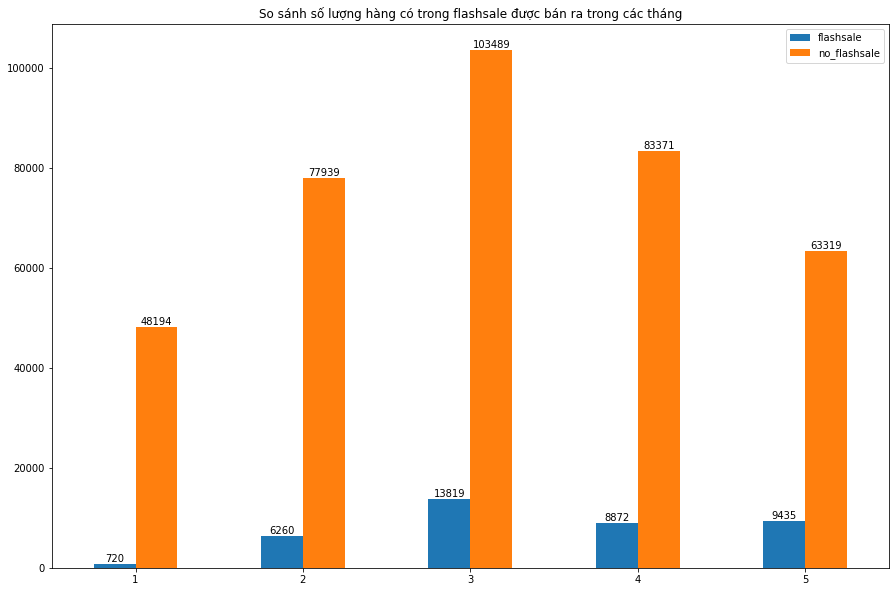

In [86]:
X = set(fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.month).keys)
index = list(X)
df = pd.DataFrame({'flashsale': flash_sale_product_2022,
                   'no_flashsale': no_flash_sale_product_2022}, index=index)
ax = df.plot.bar(rot = 0, figsize = (15, 10), title = 'So sánh số lượng hàng có trong flashsale được bán ra trong các tháng')
for container in ax.containers:
    ax.bar_label(container)

- Có thể thấy được phần trăm hàng flash_sale có vẻ không chiếm quá nhiều, tuy nhiên cách so sánh này có vẻ hơi bias, ta sẽ xem thử trung bình hàng tháng số lượng hàng flashsale chiếm bao nhiêu phần trăm số lượng hàng được tung ra để có cái nhìn khách quan hơn.
- Ta cũng có thể đánh giá nhanh rằng flashsale không ảnh hưởng qúa nhiều đến lưu lượng bán

## Ở trên chỉ mới là so sánh lưu lượng của sản phẩm flash sale tổng thể, hãy thử vào sâu hơn như là so sánh lưu lượng mua bán trong ngày của 1 loại sản phẩm flashsale so với không có flashsale

In [87]:
# xác định các đơn hàng được đặt trong khoảng thời gian này
# query các cột có cùng mãu sku
fhs_not_flashsale_product_order_complete_2022 = \
          pd.merge(fhs_sales_flat_order_complete_item_2022, fhs_flashsale_product_info_2022, how = 'inner',
                    left_on = 'fhs_sales_flat_order_item.sku', right_on='fhs_catalog_product_entity.sku')


# sau đó đặt điều kiện về ngày sao cho ngày đặt của các sản phẩm phải không trong thời gian flashsale và cùng ngày
fhs_not_flashsale_day_product_order_complete_2022 = fhs_not_flashsale_product_order_complete_2022.loc[
          np.invert((fhs_not_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
                    > fhs_not_flashsale_product_order_complete_2022['fhs_flashsale_period.start_date'])
&         (fhs_not_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
                    < fhs_not_flashsale_product_order_complete_2022['fhs_flashsale_period.end_date']))
&         (fhs_not_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.day_of_year \
                    == fhs_not_flashsale_product_order_complete_2022['fhs_flashsale_period.end_date'].dt.day_of_year)]

# nhớ loại bỏ các duplicate: ở đây ta dùng cách drop ducplicate ở left dataframe
# vì mỗi một đơn hàng chỉ match với một sản phẩm bên phía sản phẩm sale
# còn mỗi một sản phẩm sale có thể có nhiều đơn hàng nên không thể drop duplicate bằng cách này
fhs_not_flashsale_day_product_order_complete_2022.drop_duplicates(subset = fhs_sales_flat_order_complete_item_2022.columns, 
          inplace = True)
          
fhs_not_flashsale_day_product_order_complete_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49382 entries, 11655 to 9009701
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   fhs_sales_flat_order.entity_id               49382 non-null  int64         
 1   fhs_sales_flat_order.increment_id            49382 non-null  float64       
 2   fhs_sales_flat_order.state                   49382 non-null  object        
 3   fhs_sales_flat_order.status                  49382 non-null  object        
 4   fhs_sales_flat_order.created_at              49382 non-null  datetime64[ns]
 5   fhs_sales_flat_order.updated_at              49382 non-null  datetime64[ns]
 6   fhs_sales_flat_order.store_id                49382 non-null  int64         
 7   fhs_sales_flat_order_item.item_id            49382 non-null  int64         
 8   fhs_sales_flat_order_item.order_id           49382 non-null  int64    

/tmp/ipykernel_5027/6493813.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fhs_not_flashsale_day_product_order_complete_2022.drop_duplicates(subset = fhs_sales_flat_order_complete_item_2022.columns,


In [88]:
# Ta group by theo tháng lần lượt hàng flashsale và hàng không flashsale trong ngày
flash_sale_product_2022 = fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.month).count()
no_flash_sale_day_product_2022 = fhs_not_flashsale_day_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_not_flashsale_day_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.month).count()

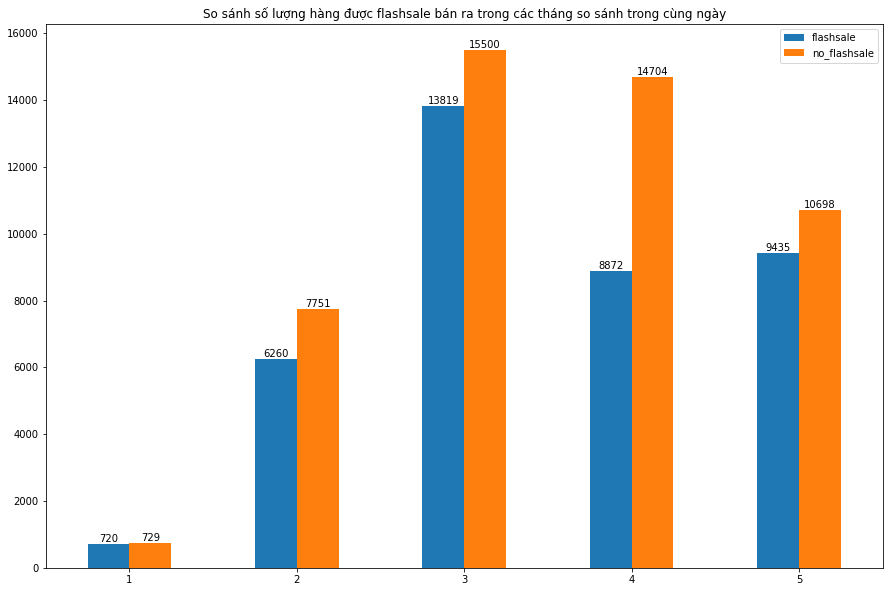

In [89]:
X = set(fhs_not_flashsale_day_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_not_flashsale_day_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.month).keys)
index = list(X)
df = pd.DataFrame({'flashsale': flash_sale_product_2022,
                   'no_flashsale': no_flash_sale_day_product_2022}, index=index)
ax = df.plot.bar(rot = 0, figsize = (15, 10), 
          title = 'So sánh số lượng hàng được flashsale bán ra trong các tháng so sánh trong cùng ngày')
for container in ax.containers:
    ax.bar_label(container)

- Tiếp theo so sánh lưu lượng mua hàng ở các ngày có flash sale và các ngày không flash sale để xem thử liệu nghe thông báo flash sale khách hàng có hứng thú hay không (lưu ý khi nãy giờ chúng ta chỉ so sánh lưu lượng mua của hàng flash sale chứ không xét đến ngày flash sale hàng hóa có mua nhiều hơn không)

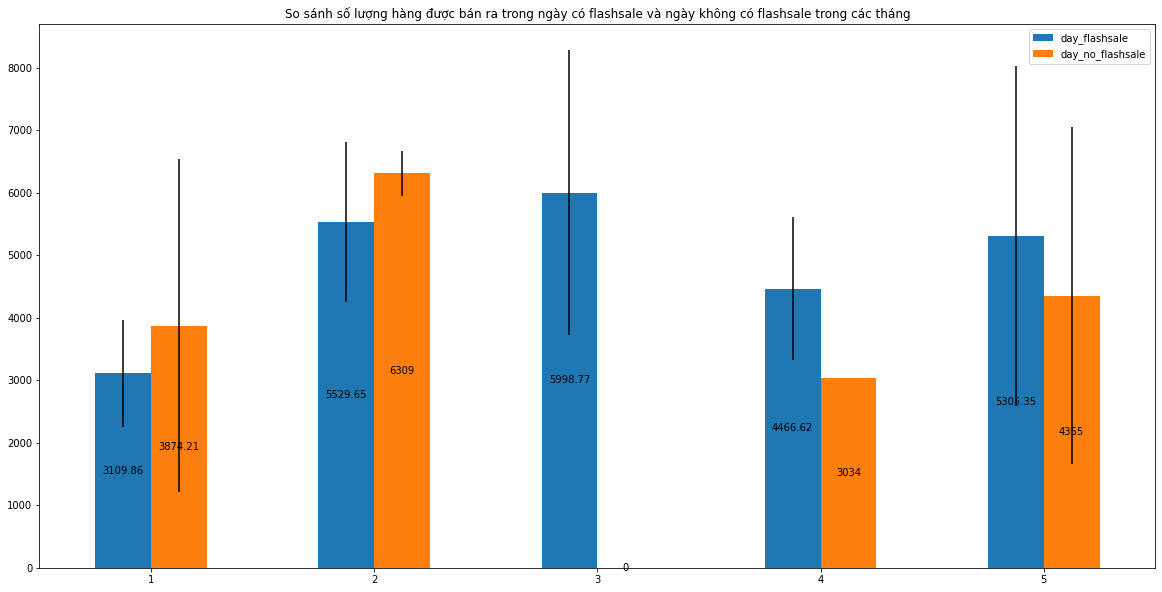

In [90]:

# Lấy ra những ngày mà hôm đấy có flashsale
flashsale_days = set(fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear).keys)

# Những ngày bán hàng trong năm 2022
day_of_year = set(fhs_sales_flat_order_complete_item_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_sales_flat_order_complete_item_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear).keys)

# Những ngày có trong flashsale mang giá trị true để lọc ra
fhs_sales_flat_order_complete_item_2022['is_flashsale'] = \
          fhs_sales_flat_order_complete_item_2022['fhs_sales_flat_order_item.created_at']\
                    .map(lambda x:  True if x.dayofyear in  flashsale_days else False)


# Lọc ra những dòng của bán hàng trong ngày flashsale
fhs_all_product_order_complete_in_flashsale_day_2022 = \
          fhs_sales_flat_order_complete_item_2022.loc[fhs_sales_flat_order_complete_item_2022['is_flashsale']]
# Lọc ra những dòng không phải của ngày flashsale
fhs_all_product_order_complete_not_in_flashsale_day_2022 = \
          fhs_sales_flat_order_complete_item_2022.loc[np.invert(fhs_sales_flat_order_complete_item_2022['is_flashsale'])]

# Tạo ra dataframe chứa số lượng bán hàng của từng ngày của ngày có flashsale và ngày không có flashsale
count_sold_product_per_day = pd.DataFrame(\
          {'amount_flash_sale': fhs_all_product_order_complete_in_flashsale_day_2022
                                        .groupby(fhs_all_product_order_complete_in_flashsale_day_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear)
                                        ['fhs_sales_flat_order_item.created_at'].count(),
          'amount_no_day_flashsale': fhs_all_product_order_complete_not_in_flashsale_day_2022
                                        .groupby(fhs_all_product_order_complete_not_in_flashsale_day_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear)
                                        ['fhs_sales_flat_order_item.created_at'].count(),
          'date':   pd.to_datetime('2022-1-1') + pd.to_timedelta(np.subtract(np.asarray(list(day_of_year)), 1), unit='D')}
          
                    , index = day_of_year)

# Tính phương sai của số lượng hàng bán trong ngày
std_flashsale = np.asarray(count_sold_product_per_day.groupby(
    count_sold_product_per_day['date'].dt.month)['amount_flash_sale'].std().fillna(0))
std_no_flashsale = np.asarray(
    count_sold_product_per_day.groupby(count_sold_product_per_day['date'].dt.month)['amount_no_day_flashsale'].std().fillna(0))

# tạo dataframe để visualize
df2 = pd.DataFrame({'day_flashsale': count_sold_product_per_day.groupby(count_sold_product_per_day['date'].dt.month)
                                        ['amount_flash_sale'].mean().fillna(0),
                   'day_no_flashsale': count_sold_product_per_day.groupby(count_sold_product_per_day['date'].dt.month)
                                        ['amount_no_day_flashsale'].mean().fillna(0)}, index=index)

ax = df2.plot.bar(rot = 0, figsize = (20, 10), 
          title = 'So sánh số lượng hàng được bán ra trong ngày có flashsale và ngày không có flashsale trong các tháng',
          yerr = [std_flashsale, std_no_flashsale])

for container in ax.containers[1::2]:
    ax.bar_label(container, label_type='center')


/tmp/ipykernel_5027/3017134373.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = count_sold_product_per_day.groupby(


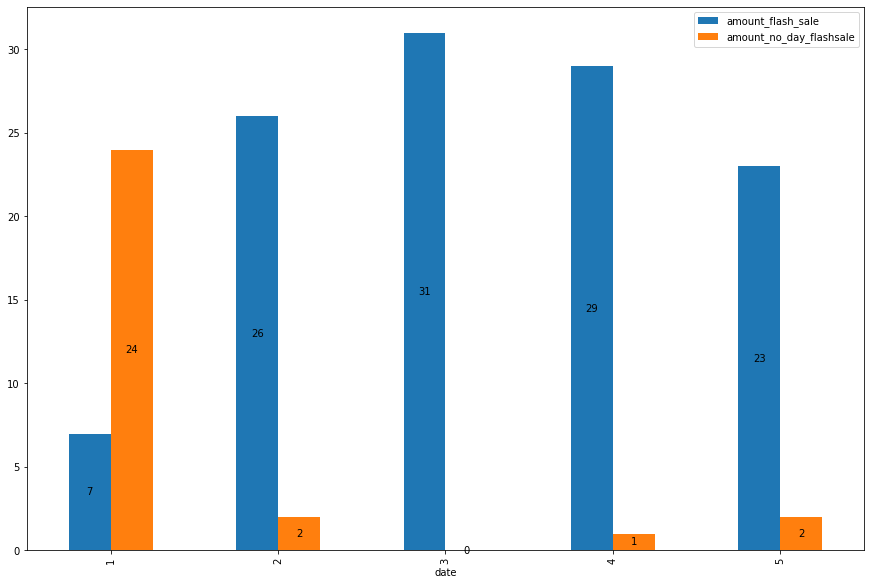

In [91]:
df = count_sold_product_per_day.groupby(
          count_sold_product_per_day['date'].dt.month)['amount_flash_sale', 'amount_no_day_flashsale'].count();

df.rename({'amount_flash_sale': 'day_flash_sale',
          'amount_no_day_flashsale': 'day_no_flashsale'}, inplace = True)

ax = df.plot.bar(figsize = (15,10))
for container in ax.containers:
    ax.bar_label(container, label_type='center')

In [92]:
# a = pd.merge(fhs_sales_flat_order_complete_item_2022, fhs_flashsale_product_info_2022, how = 'inner',
#                     left_on = 'fhs_sales_flat_order_item.sku', right_on='fhs_catalog_product_entity.sku')

a = fhs_sales_flat_order_complete_item_2022['fhs_sales_flat_order_item.sku']\
          .isin(fhs_flashsale_product_info_2022['fhs_catalog_product_entity.sku'])

### Ta sẽ thử đi sâu vào so sánh lưu lượng mua hàng của ngày không flashsale và ngày flashsale của hàng flashsale xem thử có thúc đẩy hàng hóa hay không

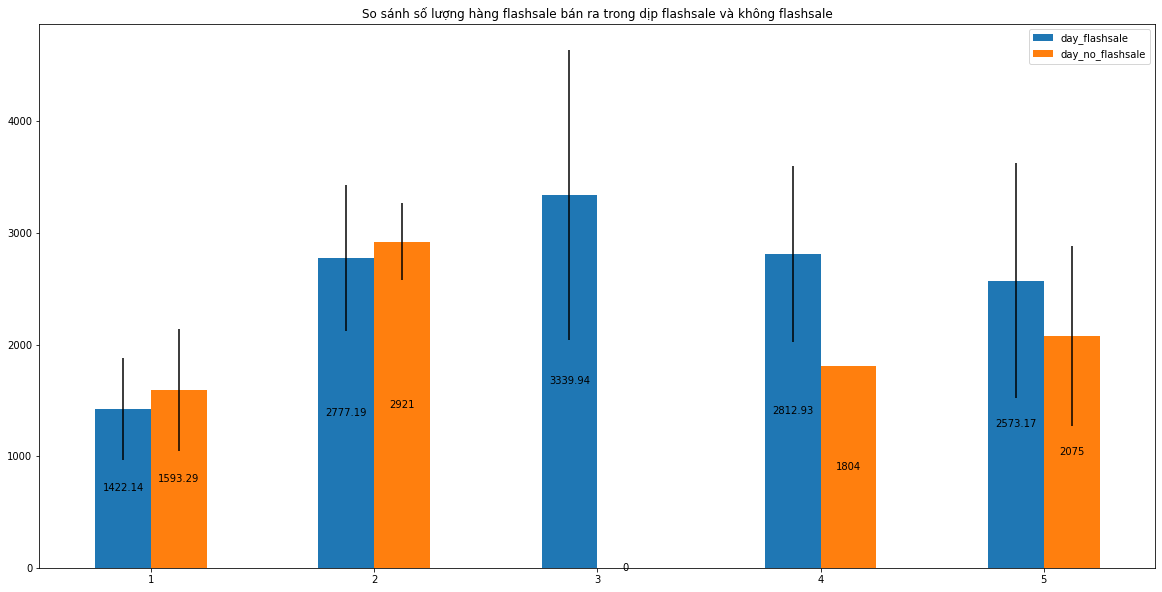

In [93]:
# Xác định các sản phẩm có trong flashsale được bán trong năm 2022
fhs_type_flashsale_product_order_complete_2022 = \
          pd.merge(fhs_sales_flat_order_complete_item_2022, fhs_flashsale_product_info_2022, how = 'inner',
                    left_on = 'fhs_sales_flat_order_item.sku', right_on='fhs_catalog_product_entity.sku')

# nhớ loại bỏ các duplicate: ở đây ta dùng cách drop ducplicate ở left dataframe
# vì mỗi một đơn hàng chỉ match với một sản phẩm bên phía sản phẩm sale
# còn mỗi một sản phẩm sale có thể có nhiều đơn hàng nên không thể drop duplicate bằng cách này
fhs_type_flashsale_product_order_complete_2022.drop_duplicates(subset = fhs_sales_flat_order_complete_item_2022.columns, 
          inplace = True)


# Lấy ra những ngày mà hôm đấy có flashsale
flashsale_days = set(fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear).keys)

# Những ngày bán hàng trong năm 2022
day_of_year = set(fhs_type_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_type_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear).keys)

# Những ngày có trong flashsale mang giá trị true để lọc ra
fhs_type_flashsale_product_order_complete_2022['is_flashsale'] = \
          fhs_type_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at']\
                    .map(lambda x:  True if x.dayofyear in  flashsale_days else False)


# Lọc ra những dòng của bán hàng trong ngày flashsale
fhs_all_product_order_complete_in_flashsale_day_2022 = \
          fhs_type_flashsale_product_order_complete_2022.loc[fhs_type_flashsale_product_order_complete_2022['is_flashsale']]
# Lọc ra những dòng không phải của ngày flashsale
fhs_all_product_order_complete_not_in_flashsale_day_2022 = \
          fhs_type_flashsale_product_order_complete_2022.loc[np.invert(fhs_type_flashsale_product_order_complete_2022['is_flashsale'])]

# Tạo ra dataframe chứa số lượng bán hàng của từng ngày của ngày có flashsale và ngày không có flashsale
count_sold_product_per_day = pd.DataFrame(\
          {'amount_flash_sale': fhs_all_product_order_complete_in_flashsale_day_2022
                                        .groupby(fhs_all_product_order_complete_in_flashsale_day_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear)
                                        ['fhs_sales_flat_order_item.created_at'].count(),
          'amount_no_day_flashsale': fhs_all_product_order_complete_not_in_flashsale_day_2022
                                        .groupby(fhs_all_product_order_complete_not_in_flashsale_day_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear)
                                        ['fhs_sales_flat_order_item.created_at'].count(),
          'date':   pd.to_datetime('2022-1-1') + pd.to_timedelta(np.subtract(np.asarray(list(day_of_year)), 1), unit='D')}
          
                    , index = day_of_year)

# Tính phương sai của số lượng hàng bán trong ngày
std_flashsale = np.asarray(count_sold_product_per_day.groupby(
    count_sold_product_per_day['date'].dt.month)['amount_flash_sale'].std().fillna(0))
std_no_flashsale = np.asarray(
    count_sold_product_per_day.groupby(count_sold_product_per_day['date'].dt.month)['amount_no_day_flashsale'].std().fillna(0))

# tạo dataframe để visualize
df2 = pd.DataFrame({'day_flashsale': count_sold_product_per_day.groupby(count_sold_product_per_day['date'].dt.month)
                                        ['amount_flash_sale'].mean().fillna(0),
                   'day_no_flashsale': count_sold_product_per_day.groupby(count_sold_product_per_day['date'].dt.month)
                                        ['amount_no_day_flashsale'].mean().fillna(0)}, index=index)

ax = df2.plot.bar(rot = 0, figsize = (20, 10), 
          title = 'So sánh số lượng hàng flashsale bán ra trong dịp flashsale và không flashsale',
          yerr = [std_flashsale, std_no_flashsale])

for container in ax.containers[1::2]:
    ax.bar_label(container, label_type='center')


- Có thể thấy phương sai là khá lớn, hãy thử xem liệu có phải chủ yếu khách sẽ mua hàng vào các ngày cuối tuần hay không

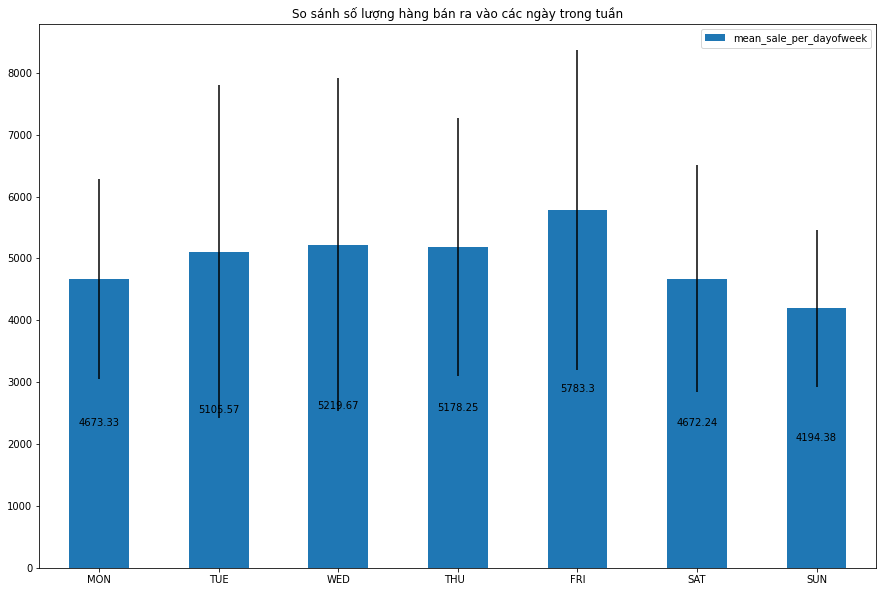

In [94]:
# Đếm số hàng bán ra mỗi ngày
fhs_sales_flat_order_complete_item_2022_count_day = fhs_sales_flat_order_complete_item_2022\
          .groupby(fhs_sales_flat_order_complete_item_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear)\
                    .count()['fhs_sales_flat_order_item.created_at']

# Những ngày bán hàng trong năm 2022
day_of_year = set(fhs_sales_flat_order_complete_item_2022['fhs_sales_flat_order_item.created_at'] \
          .groupby(fhs_sales_flat_order_complete_item_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear).keys)

df = pd.DataFrame({'sale_per_day_of_year': fhs_sales_flat_order_complete_item_2022_count_day,
                    'date': pd.to_datetime('2022-1-1') + pd.to_timedelta(np.subtract(np.asarray(list(day_of_year)), 1), unit='D')},
                    index = day_of_year)

std = df.groupby(df['date'].dt.dayofweek)['sale_per_day_of_year'].std().fillna(0)

df2 = pd.DataFrame({'mean_sale_per_dayofweek': df.groupby(df['date'].dt.dayofweek)['sale_per_day_of_year'].mean().fillna(0)},
                    index = [0, 1, 2, 3, 4, 5, 6])

ax = df2.plot.bar(rot = 0, figsize = (15, 10), 
          title = 'So sánh số lượng hàng bán ra vào các ngày trong tuần',
          yerr = std)

for container in ax.containers[1::2]:
    ax.bar_label(container, label_type='center')

ax.set_xticks([0, 1, 2, 3, 4, 5, 6], ['MON','TUE','WED','THU  ','FRI','SAT','SUN']);


In [95]:
fhs_sales_flat_order_complete_item_2022.iloc[2, 4].dayofweek

4

## Tiếp theo ta thử show ra tỉ lệ giữa hàng bán được so với hàng tung ra

In [96]:
# Ta có được số lượng hàng bán qua từng tháng
flash_sale_product_2022 
# Ta lấy tống lượng hàng flashsale tung ra để bán
no_flash_sale_product_2022 = fhs_flashsale_product_info_2022['fhs_flashsale_product.total_items']\
          .groupby(fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'].dt.month).sum()

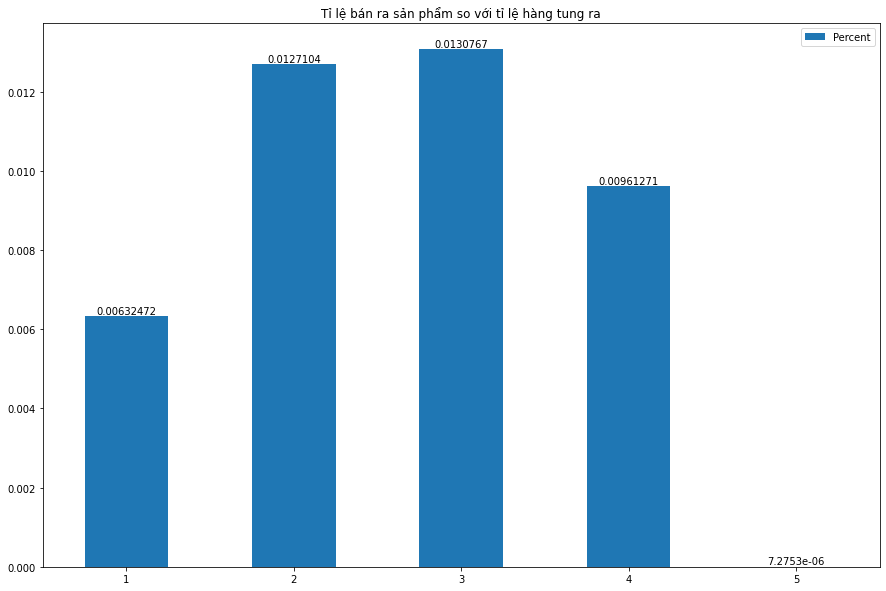

In [97]:
X = set(fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'] \
          .groupby(fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'].dt.month).keys)
index = list(X)

percentage_flashsale = flash_sale_product_2022.to_numpy()/no_flash_sale_product_2022.to_numpy()

df = pd.DataFrame({'Percent': percentage_flashsale}, index = index)
ax = df.plot.bar(rot = 0, figsize = (15, 10), title = 'Tỉ lệ bán ra sản phẩm so với tỉ lệ hàng tung ra')
for container in ax.containers:
    ax.bar_label(container)

### Cách tính trung bình mang đến kết quả:
- Flashsale thực sự không thúc đẩy đến việc bán hàng và thậm chí phần trăm chiếm rất thấp 
- Ta cần phải tính sâu vào hơn xem thử những mặt hàng nào được bán chạy hơn và những mặt hàng nào không bán được khiến cho tỉ lệ phần trăm thấp như vậy. Từ đó thúc đẩy bán thêm những sản phẩm bán chạy, và loại bỏ dần những sản phẩm không ai mua
- 

- cat, giá, thời gian phát hành, discount, thời gian mua theo ngày trong tuần

In [98]:
# # merge với product_dim để có dc cat của sản phẩm
# fhs_flashsale_product_order_complete_2022 = \
#           pd.merge(fhs_flashsale_product_order_complete_2022, product_dim,
#                     left_on = fhs_flashsale_product_order_complete_2022['fhs_catalog_product_entity.sku'],
#                     right_on = product_dim['product_dim.sku'])


- Ta có thể nhận thấy việc trùng lập nhưng khác catagories xảy ra ít nên ta có thể bỏ qua vấn đề này và drop đi duplicate

In [121]:
temp = product_dim.drop_duplicates(subset = 
          ['product_dim.sku','product_dim.cat1', 'product_dim.cat2','product_dim.cat3', 'product_dim.cat4'])
print(len(temp))
print(len(product_dim.drop_duplicates(subset = ['product_dim.sku'])))

302518
302469


In [122]:
# dropduplicate
product_dim.drop_duplicates(
          subset = ['product_dim.sku','product_dim.cat1', 'product_dim.cat2','product_dim.cat3', 'product_dim.cat4'],
          inplace=True)

# merge với product_dim để có dc cat của sản phẩm
fhs_flashsale_product_order_complete_2022 = \
          pd.merge(fhs_flashsale_product_order_complete_2022, product_dim,
                    left_on = fhs_flashsale_product_order_complete_2022['fhs_catalog_product_entity.sku'],
                    right_on = product_dim['product_dim.sku'])

fhs_sales_flat_order_complete_item_2022 = \
          pd.merge(fhs_sales_flat_order_complete_item_2022, product_dim,
                    left_on = fhs_sales_flat_order_complete_item_2022['fhs_catalog_product_entity.sku'],
                    right_on = product_dim['product_dim.sku'])



fhs_flashsale_product_order_complete_2022.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39110 entries, 0 to 39109
Data columns (total 34 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   key_0                                        39110 non-null  object        
 1   fhs_sales_flat_order.entity_id               39110 non-null  int64         
 2   fhs_sales_flat_order.increment_id            39110 non-null  float64       
 3   fhs_sales_flat_order.state                   39110 non-null  object        
 4   fhs_sales_flat_order.status                  39110 non-null  object        
 5   fhs_sales_flat_order.created_at              39110 non-null  datetime64[ns]
 6   fhs_sales_flat_order.updated_at              39110 non-null  datetime64[ns]
 7   fhs_sales_flat_order.store_id                39110 non-null  int64         
 8   fhs_sales_flat_order_item.item_id            39110 non-null  int64         


In [154]:
temp = fhs_flashsale_product_order_complete_2022\
          .groupby(['product_dim.cat1', 
                    'is_flashsale', 
                    fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.month])\
                    ['key_0'].count()

ax = temp.plot.barh(figsize = (20,15), color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'], 
                title = 'Số lượng CAT flashsale và không flashsale bán theo tháng')

for container in ax.containers:
    ax.bar_label(container)

KeyError: 'is_flashsale'

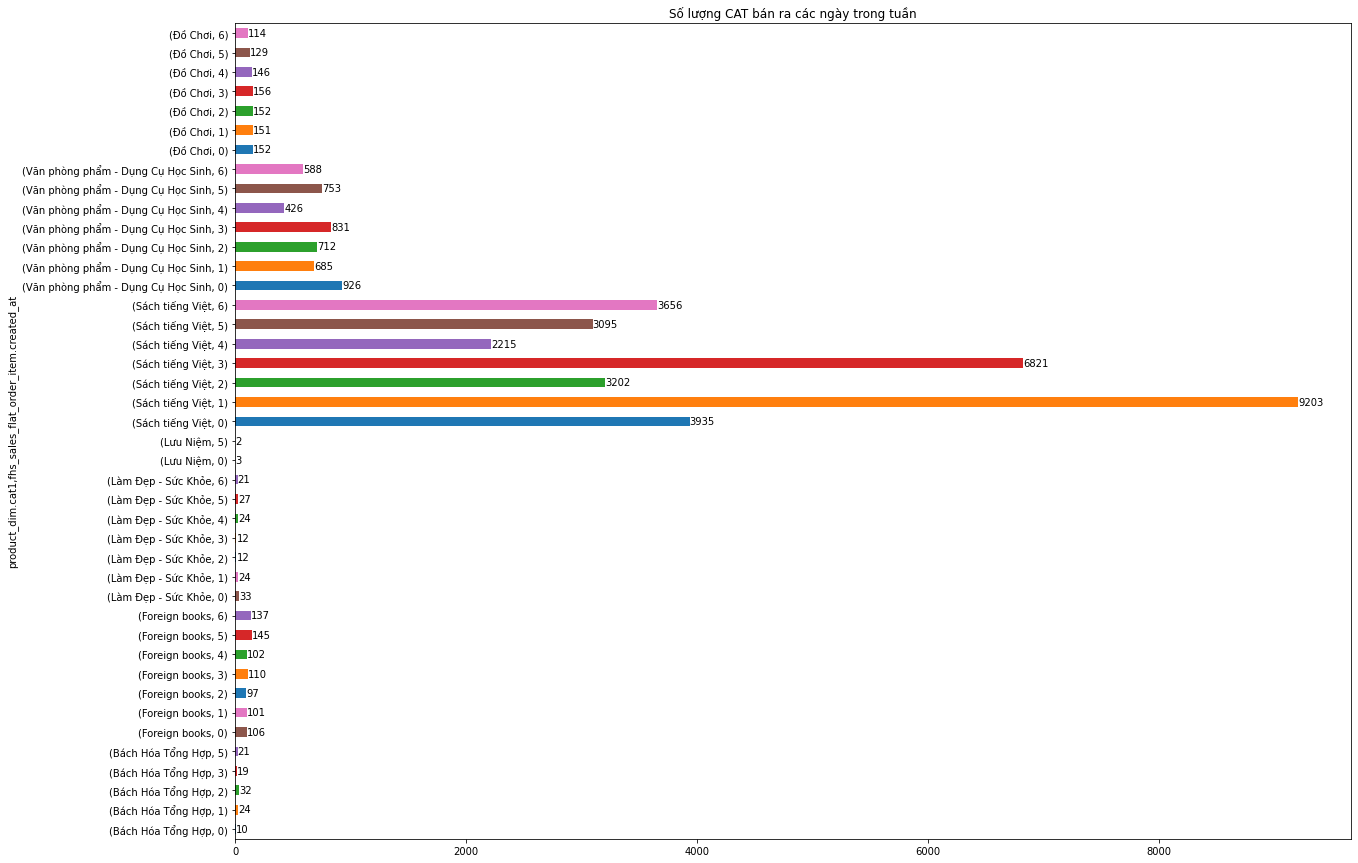

In [155]:

temp = fhs_flashsale_product_order_complete_2022\
          .groupby(['product_dim.cat1', 
                    fhs_flashsale_product_order_complete_2022['fhs_sales_flat_order_item.created_at'].dt.dayofweek] )\
                    ['key_0'].count()

ax = temp.plot.barh(figsize = (20,15), color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'], 
                title = 'Số lượng CAT bán ra các ngày trong tuần')
for container in ax.containers:
    ax.bar_label(container)

<AxesSubplot:title={'center':'Số lượng bán hàng flashsale của category: Sách tiếng Việt'}, xlabel='product_dim.cat2'>

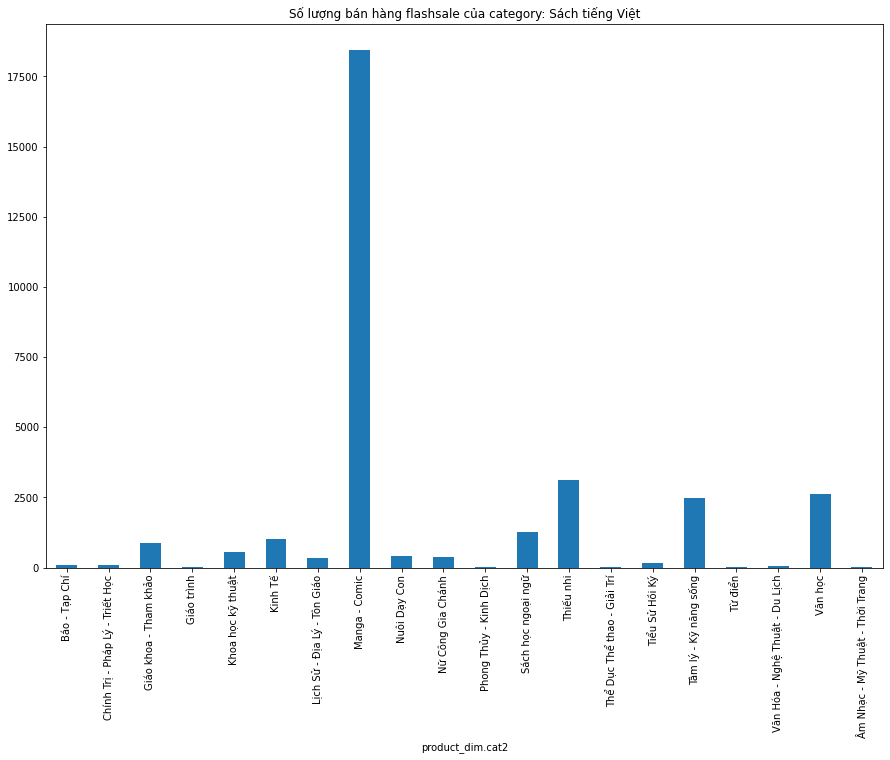

In [152]:
df = fhs_flashsale_product_order_complete_2022\
          .loc[fhs_flashsale_product_order_complete_2022['product_dim.cat1'] == 'Sách tiếng Việt']

temp = df.groupby(['product_dim.cat2'])['key_0'].count()
temp.plot.bar(figsize = (15, 10), title = 'Số lượng bán hàng flashsale của category: Sách tiếng Việt')

- tái sử dụng hàm bên trên để tính tiếp liệu bình thường và ngày flash sale những cat có được đẩy mạnh hay không

- Vẽ một đường xem ở phần trăm discount bao nhiêu thì flashsale bán chạy nhất

- Tương tự với thời gian mua